Graph Neural Networks (GNNs) represent one of the most captivating and rapidly evolving architectures within the deep learning landscape. As deep learning models designed to process data structured as graphs, GNNs bring remarkable versatility and powerful learning capabilities.

Among the various types of GNNs, the Graph Convolutional Networks (GCNs) have emerged as the most prevalent and broadly applied model. GCNs are innovative due to their ability to leverage both the features of a node and its locality to make predictions, providing an effective way to handle graph-structured data.

In this article, we will delve into the mechanics of the GCN layer and explain its inner workings. Furthermore, we will explore its practical application for node classification tasks, using PyTorch Geometric as our tool of choice.

PyTorch Geometric is a specialized extension of PyTorch that has been created specifically for the development and implementation of GNNs. It is an advanced, yet user-friendly library that provides a comprehensive suite of tools to facilitate graph-based machine learning. To commence our journey, the PyTorch Geometric installation will be required. If you are using Google Colab, PyTorch should already be in place, so all we need to do is execute a few additional commands.

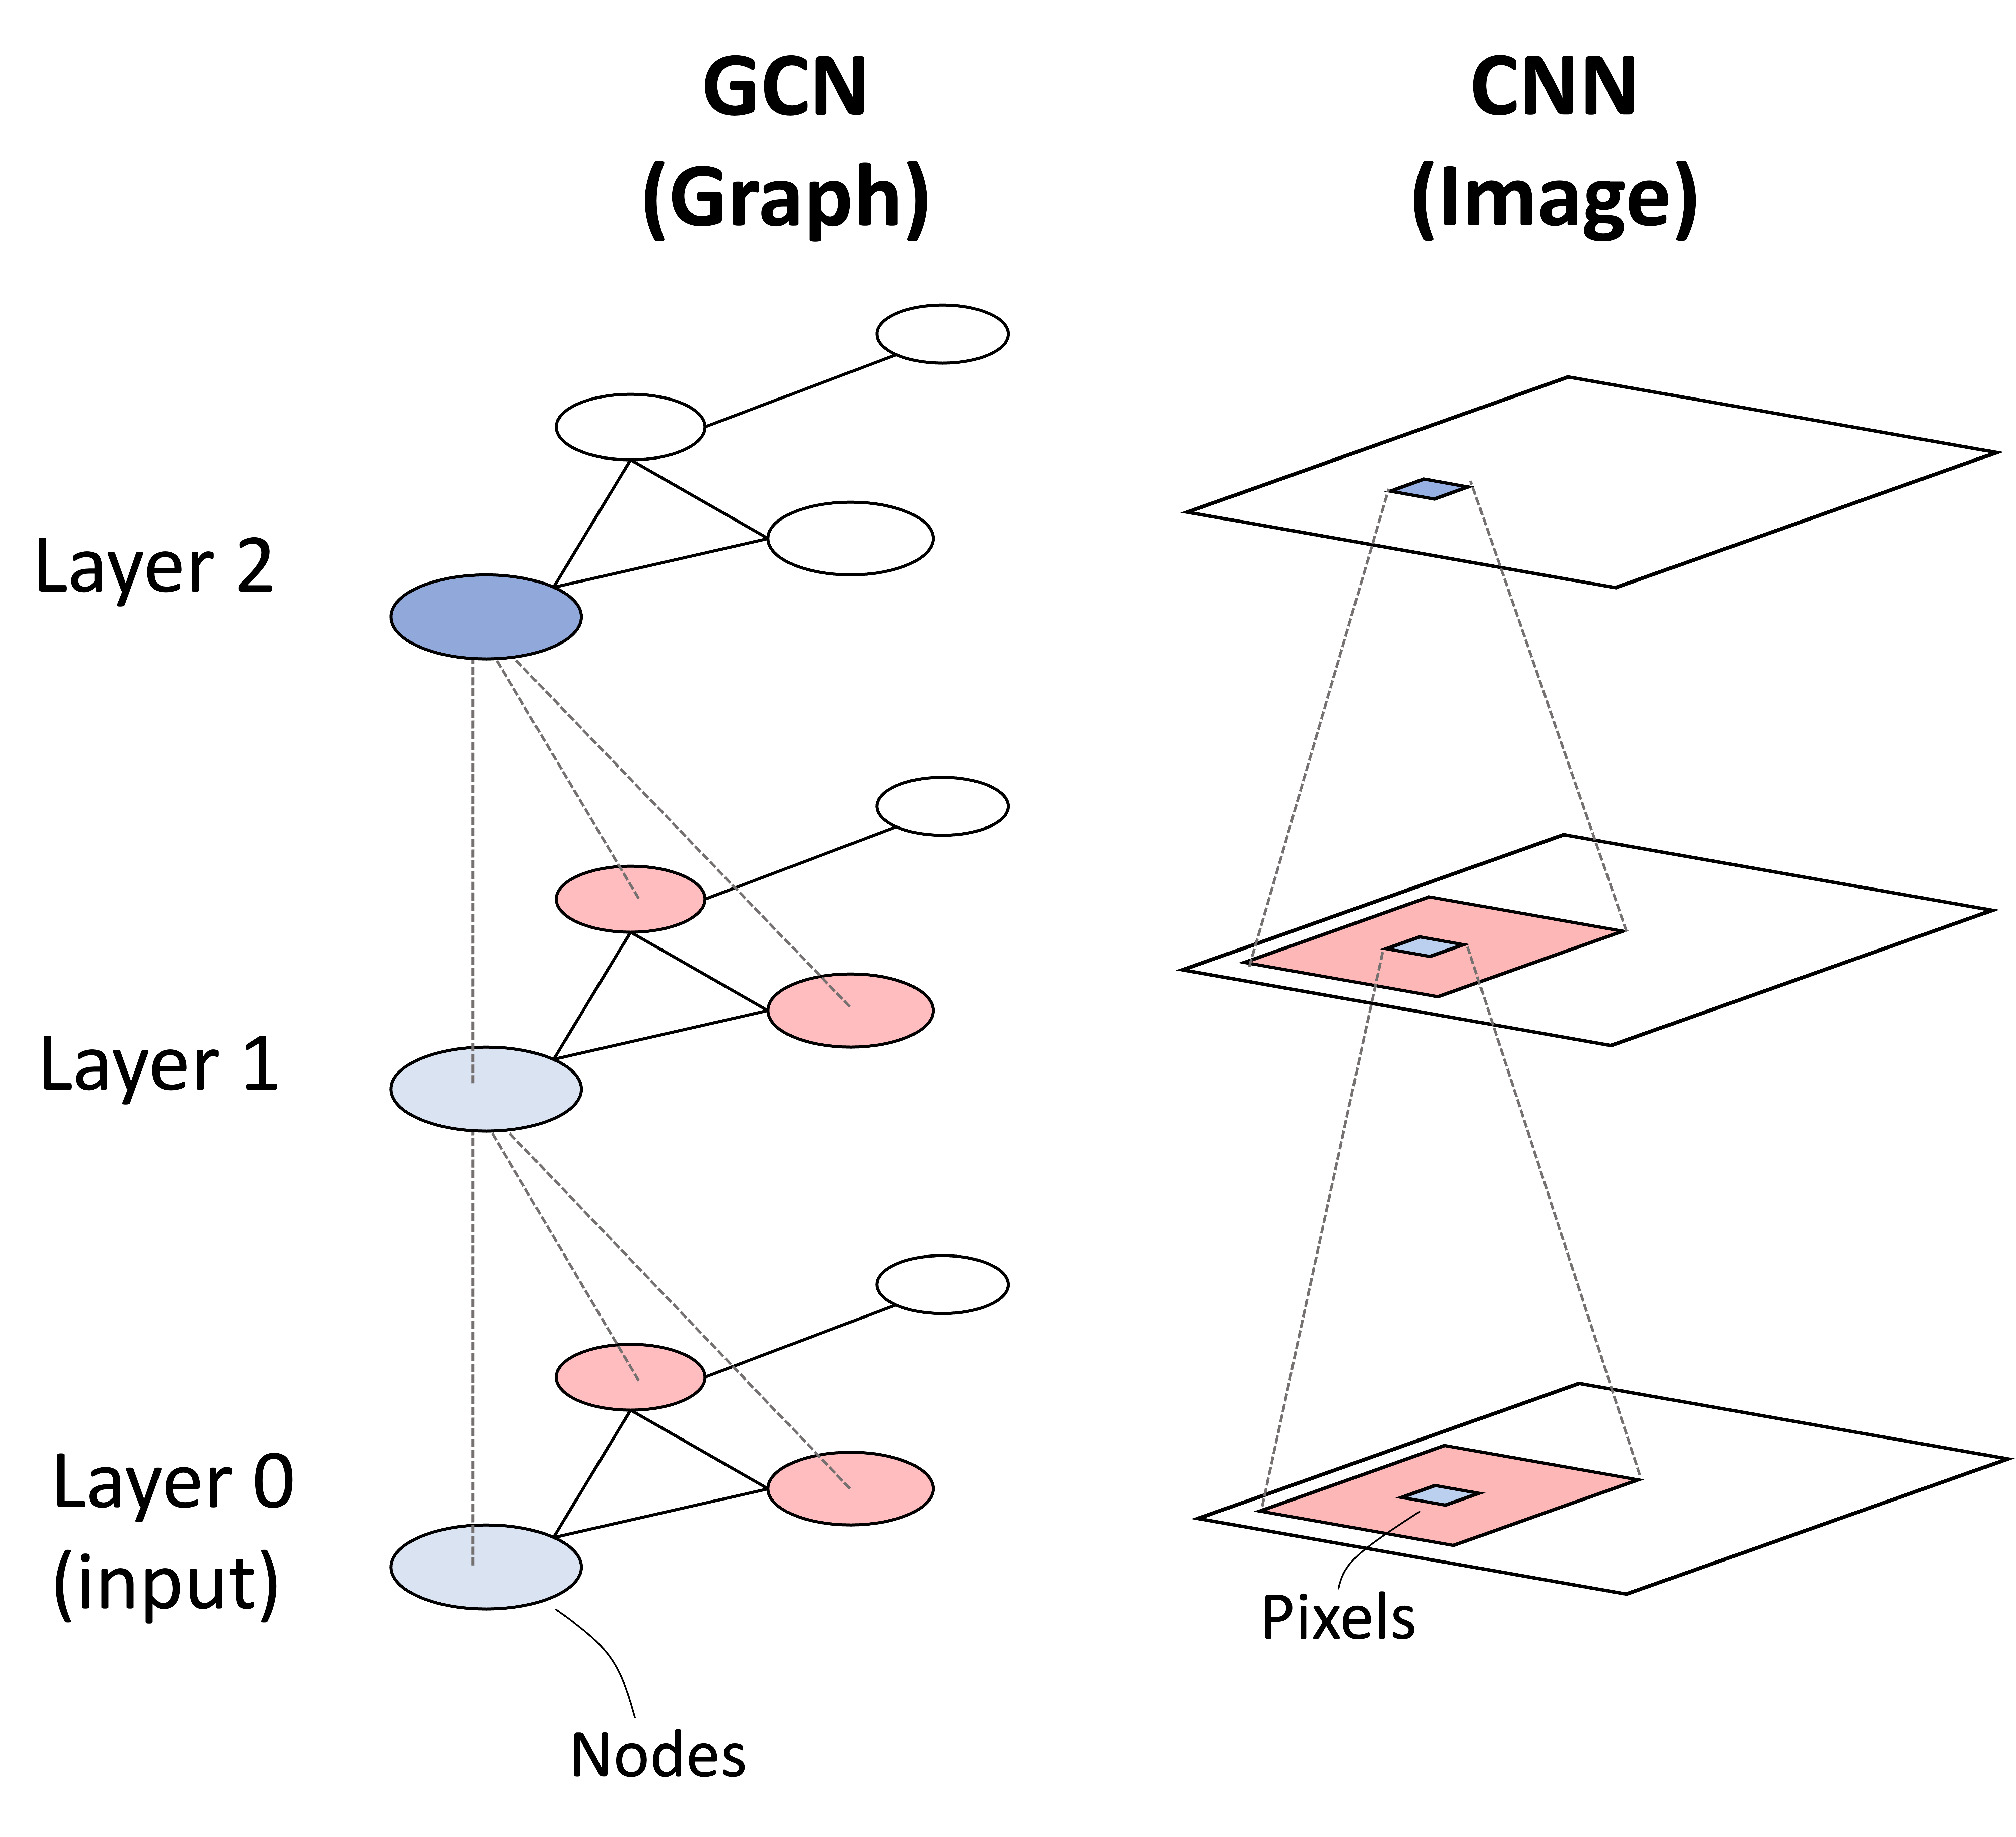

In [ ]:
!pip -q install torch_geometric==2.6.1
!pip install imageio-ffmpeg

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import torch_geometric
print(torch_geometric.__version__)

# **1. Graph data**

Graphs are an essential structure for representing relationships between objects. You can encounter graph data in a multitude of real-world scenarios, such as social and computer networks, chemical structures of molecules, natural language processing, and image recognition, to name a few.

In this article, we will study the infamous and much-used **Zachary’s karate club** dataset.

The Zachary’s karate club dataset embodies the relationships formed within a karate club as observed by Wayne W. Zachary during the 1970s. It is a kind of social network, where each node represents a club member, and edges between nodes represent interactions that occurred outside the club environment.

In this particular scenario, the members of the club are split into four distinct groups. Our task is to assign the correct group to each member (node classification), based on the pattern of their interactions.

Let’s import the dataset with PyG’s built-in function and try to understand the Datasets object it uses.


In [ ]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

This dataset only has 1 graph, where each node has a feature vector of 34 dimensions and is part of one out of four classes (our four groups). Actually, the Datasets object can be seen as a collection of Data (graph) objects.

We can further inspect our unique graph to know more about it.

In [ ]:
# Print first element
print(f'Graph: {dataset[0]}')

The Data object is particularly interesting. Printing it offers a good summary of the graph we’re studying:


*   **x=[34, 34]** is the node feature matrix with shape (number of nodes, number of features). In our case, it means that we have 34 nodes (our 34 members), each node being associated to a 34-dim feature vector.
*  **edge_index=[2, 156]** represents the graph connectivity (how the nodes are connected) with shape (2, number of directed edges).

*   **y=[34]** is the node ground-truth labels. In this problem, every node is assigned to one class (group), so we have one value for each node.
*   **train_mask=[34]** is an optional attribute that tells which nodes should be used for training with a list of *True* or *False* statements.


Let’s print each of these tensors to understand what they store. Let’s start with the node features.

In [ ]:
data = dataset[0]

print(f'x = {data.x.shape}')
print(data.x)

Here, the node feature matrix x is an identity matrix: it doesn’t contain any relevant information about the nodes. It could contain information like age, skill level, etc. but this is not the case in this dataset. It means we’ll have to classify our nodes just by looking at their connections.

Now, let’s print the edge index.

In [ ]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

In graph theory and network analysis, connectivity between nodes is stored using a variety of data structures. The `edge_index` is one such data structure, where the graph’s connections are stored in **two lists** (156 directed edges, which equate to 78 bidirectional edges). The reason for these two lists is that one list stores the source nodes, while the second one identifies the destination nodes.

This method is known as a **coordinate list (COO) format**, which is essentially a means to efficiently store a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). Sparse matrices are data structures that efficiently store matrices with a majority of zero elements. In the COO format, only non-zero elements are stored, saving memory and computational resources.

Contrarily, a more intuitive and straightforward way to represent graph connectivity is through an **adjacency matrix** $\mathbf{A}$. This is a square matrix where each element $A_{ij}$ specifies the presence or absence of an edge from node $i$ to node $j$ in the graph. In other words, a non-zero element $A_{ij}$ implies a connection from node $i$ to node $j$, and a zero indicates no direct connection.



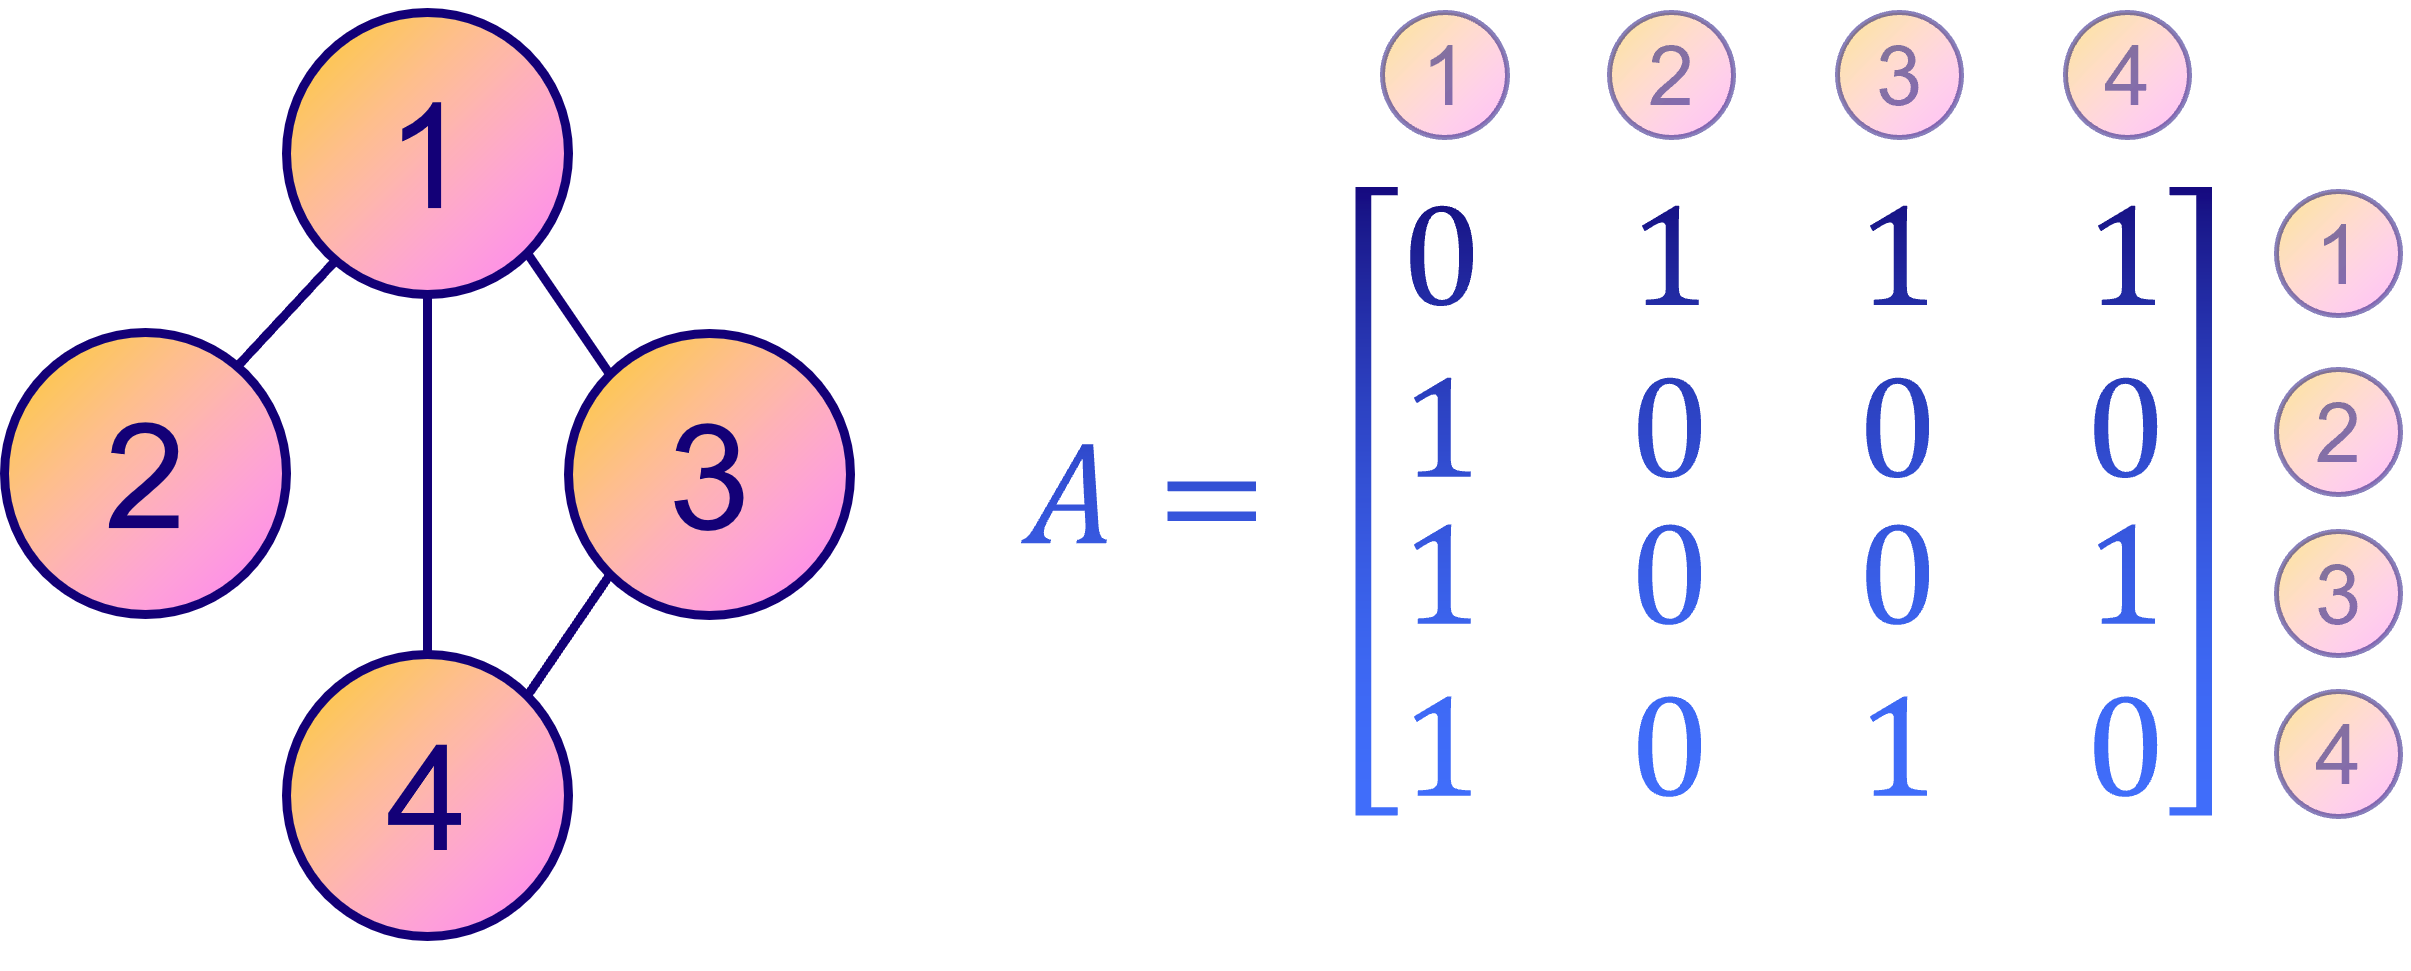

An adjacency matrix, however, is not as space-efficient as the COO format for sparse matrices or graphs with fewer edges. However, for clarity and easy interpretation, the adjacency matrix remains a popular choice for representing graph connectivity.

The adjacency matrix can be inferred from the **edge_index** with a utility function **to_dense_adj()**.

In [ ]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

With graph data, it is relatively uncommon for nodes to be densely interconnected. As you can see, our adjacency matrix $A$ is **sparse** (filled with zeros).

In many real-world graphs, most nodes are connected to only a few other nodes, resulting in a large number of zeros in the adjacency matrix. Storing so many zeros is not efficient at all, which is why the COO format is adopted by PyG.

On the contrary, ground-truth labels are easy to understand.

In [ ]:
print(f'y = {data.y.shape}')
print(data.y)

Our node ground-truth labels stored in $y$ simply encode the group number (0, 1, 2, 3) for each node, which is why we have 34 values.

Finally, let’s print the train mask.

In [ ]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

The train mask shows which nodes are supposed to be used for training with True statements. These nodes represent the training set, while the others can be considered as the test set. This division helps in model evaluation by providing unseen data for testing.

But we’re not done yet! The Data object has a lot more to offer. It provides various utility functions that enable the investigation of several properties of the graph. For instance:


*   **is_directed()** tells you if the graph is directed. A directed graph signifies that the adjacency matrix is not symmetric, i.e., the direction of edges matters in the connections between nodes.
*   **isolated_nodes()** checks if some nodes are not connected to the rest of the graph. These nodes are likely to pose challenges in tasks like classification due to their lack of connections.


*   **has_self_loops()** indicates if at least one node is connected to itself. This is distinct from the concept of []loops: a loop implies a path that starts and ends at the same node, traversing other nodes in between.


In the context of the Zachary’s karate club dataset, all these properties return False. This implies that the graph is not directed, does not have any isolated nodes, and none of its nodes are connected to themselves.

In [ ]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Finally, we can convert a graph from PyTorch Geometric to the popular graph library [NetworkX](https://networkx.org/) using `to_networkx`. This is particularly useful to visualize a small graph with `networkx` and `matplotlib`.

Let’s plot our dataset with a different color for each group.


In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

This plot of Zachary’s karate club displays our 34 nodes, 78 (bidirectional) edges, and 4 labels with 4 different colors. Now that we’ve seen the essentials of loading and handling a dataset with PyTorch Geometric, we can introduce the Graph Convolutional Network architecture.

## 2. Graph Convolutional Network

This section aims to introduce and build the graph convolutional layer from the ground up.

In traditional neural networks, linear layers apply a **linear transformation** to the incoming data. This transformation converts input features $\mathbf{x}$ into hidden vectors $\mathbf{h}$ through the use of a weight matrix $\mathbf{W}$. Ignoring biases for the time being, this can be expressed as:

$$ \mathbf{h} = \mathbf{W} \mathbf{x} $$

With graph data, an additional layer of complexity is added through the connections between nodes. These connections matter because, typically, in networks, it’s assumed that similar nodes are more likely to be linked to each other than dissimilar ones, a phenomenon known as network homophily.

We can enrich our **node representation** by merging its features with those of its neighbors. This operation is called convolution, or neighborhood aggregation. Let’s represent the neighborhood of node $i$ including itself as $N_i$:

$$ \mathbf{h}_i = \sum_{j \in N_i} \mathbf{W} \mathbf{x}_j $$

Unlike filters in Convolutional Neural Networks (CNNs), our weight matrix $\mathbf{W}$ is unique and shared among every node. But there is another issue: nodes do not have a fixed number of neighbors like pixels do.

How do we address cases where one node has only 1 neighbor, and another has 500? If we simply sum the feature vectors, the resulting embedding $\mathbf{h}$ would be much larger for the node with 500 neighbors. To ensure a similar range of values for all nodes and comparability between them, we can normalize the result based on the degree of nodes, where degree refers to the number of connections a node has.

$$ \mathbf{h}_i = \frac{1}{\text{deg}(i)} \sum_{j \in N_i} \mathbf{W} \mathbf{x}_j $$

We’re almost there! Introduced by Kipf et al. (2016), the graph convolutional layer has one final improvement.

The authors observed that features from nodes with numerous neighbors propagate much more easily than those from more isolated nodes. To offset this effect, they suggested assigning bigger weights to features from nodes with fewer neighbors, thus balancing the influence across all nodes. This operation is written as:

$$ \mathbf{h}_i = \sum_{j \in N_i} \frac{1}{\sqrt{\text{deg}(i) \cdot \text{deg}(j)}} \mathbf{W} \mathbf{x}_j $$

Note that when $i$ and $j$ have the same number of neighbors, it is equivalent to our own layer. Now, let’s see how to implement it in Python with PyTorch Geometric.


# **3. Implementing a GCN**
PyTorch Geometric provides the GCNConv function, which directly implements the graph convolutional layer.

In this example, we’ll create a basic Graph Convolutional Network with a single GCN layer, a ReLU activation function, and a linear output layer. This output layer will yield four values corresponding to our four categories, with the highest value determining the class of each node.

In the following code block, we define the GCN layer with a 3-dimensional hidden layer.

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

If we added a second GCN layer, our model would not only aggregate feature vectors from the neighbors of each node, but also from the neighbors of these neighbors.

We can stack several graph layers to aggregate more and more distant values, but there’s a catch: if we add too many layers, the aggregation becomes so intense that all the embeddings end up looking the same. This phenomenon is called over-smoothing and can be a real problem when you have too many layers.

Now that we’ve defined our GNN, let’s write a simple training loop with PyTorch. I chose a regular cross-entropy loss since it’s a multi-class classification task, with Adam as optimizer. In this article, we won’t implement a train/test split to keep things simple and focus on how GNNs learn instead.

The training loop is standard: we try to predict the correct labels, and we compare the GCN’s results to the values stored in data.y. The error is calculated by the cross-entropy loss and backpropagated with Adam to fine-tune our GNN’s weights and biases. Finally, we print metrics every 10 epochs.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Great! Without much surprise, we reach 100% accuracy on the training set (full dataset). It means that our model learned to correctly assign every member of the karate club to its correct group.

We can produce a neat visualization by animating the graph and see the evolution of the GNN’s predictions during the training process.

In [ ]:
# remove %%capture for now so we can see errors / progress
from IPython.display import HTML
import importlib
import imageio_ffmpeg
import matplotlib as mpl
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# point Matplotlib to the imageio-ffmpeg binary and force writer selection
mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()
mpl.rcParams['animation.writer'] = 'ffmpeg'

# reload animation module so it re-detects writers
importlib.reload(animation)

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    plt.clf()   # clear previous frame so drawings don't overlap
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=800,
                     node_color=outputs[i],
                     cmap="hsv",
                     vmin=-2,
                     vmax=3,
                     width=0.8,
                     edge_color="grey",
                     font_size=14
                     )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0, 200, 10),
                               interval=500, repeat=True)

# This will use ffmpeg (via imageio-ffmpeg) to produce an mp4 and embed it
HTML(anim.to_html5_video())


In [ ]:
from IPython.display import HTML, display

html = HTML(anim.to_html5_video())
display(html)


The first predictions are random, but the GCN perfectly labels every node after a while. Indeed, the final graph is the same as the one we plotted at the end of the first section. But what does the GCN really learn?

By aggregating features from neighboring nodes, the GNN learns a vector representation (or embedding) of every node in the network. In our model, the final layer just learns how to use these representations to produce the best classifications. However, embeddings are the real products of GNNs.

Let’s print the embeddings learned by our model.

In [ ]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

As you can see, embeddings do not need to have the same dimensions as feature vectors. Here, I chose to reduce the number of dimensions from 34 (dataset.num_features) to three to get a nice visualization in 3D.

Let’s plot these embeddings before any training happens, at epoch 0.

In [ ]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

We see every node from Zachary’s karate club with their true labels (and not the model’s predictions). For now, they’re all over the place since the GNN is not trained yet. But if we plot these embeddings at each step of the training loop, we’d be able to visualize what the GNN truly learns.

Let’s see how they evolve over time, as the GCN gets better and better at classifying nodes.

In [ ]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

Our Graph Convolutional Network (GCN) has effectively learned embeddings that group similar nodes into distinct clusters. This enables the final linear layer to distinguish them into separate classes with ease.

Embeddings are not unique to GNNs: they can be found everywhere in deep learning. They don’t have to be 3D either: actually, they rarely are. For instance, language models like BERT produce embeddings with 768 or even 1024 dimensions.

Additional dimensions store more information about nodes, text, images, etc. but they also create bigger models that are more difficult to train. This is why keeping low-dimensional embeddings as long as possible is advantageous.

# **4. Conclusion**

Graph Convolutional Networks are an incredibly versatile architecture that can be applied in many contexts. In this article, we familiarized ourselves with the PyTorch Geometric library and objects like Datasets and Data. Then, we successfully reconstructed a graph convolutional layer from the ground up. Next, we put theory into practice by implementing a GCN, which gave us an understanding of practical aspects and how individual components interact. Finally, we visualized the training process and obtained a clear perspective of what it involves for such a network.

Zachary’s karate club is a simplistic dataset, but it is good enough to understand the most important concepts in graph data and GNNs. Although we only talked about node classification in this article, there are other tasks GNNs can accomplish: link prediction (e.g., to recommend a friend), graph classification (e.g., to label molecules), graph generation (e.g., to create new molecules), and so on.

Beyond GCN, numerous GNN layers and architectures have been proposed by researchers. In the next article, we’ll introduce the Graph Attention Network (GAT) architecture, which dynamically computes the GCN’s normalization factor and the importance of each connection with an attention mechanism.